### Ejercicio 11

#### Importamos las librerías necesarias

In [67]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")


In [68]:
# Cargar el dataset
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target
# se cambia la clase 0 por -1 para que funcione el clasificador del voted perceptron
df.loc[df["target"]==0,"target"] = -1
df.head(2)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,-1
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,-1


#### Función para graficar el reporte de clasificación

In [76]:
def plot_classification_report_with_support(report):
    labels = list(report.keys())[:-3]  # Exclude 'accuracy', 'macro avg', 'weighted avg'
    metrics = ['precision', 'recall', 'f1-score', 'support']
    data = np.array([[report[label][metric] for metric in metrics] for label in labels])
    fig, ax = plt.subplots(figsize=(8, 4))
    cax = ax.matshow(data, cmap='coolwarm')
    plt.xticks(range(len(metrics)), metrics)
    plt.yticks(range(len(labels)), labels)
    plt.colorbar(cax)
    # Adding the text
    for (i, j), val in np.ndenumerate(data):
        ax.text(j, i, f'{val:.2f}', ha='center', va='center', color='white')
    plt.xlabel('Metrics')
    plt.ylabel('Classes')
    plt.title('Classification Report with Support')
    plt.show()

### SVM con kernel RBF


#### Dividir el dataset en conjuntos de entrenamiento y prueba

In [77]:
X = data.data
y = df.target.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


#### Definir el modelo SVM y los parámetros para Grid Search

In [71]:
svc = SVC(kernel='rbf')

# Definir el rango de hiperparámetros que queremos probar
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001]
}

#### Configurar y ejecutar Grid Search con validación cruzada

In [72]:
grid_search = GridSearchCV(svc, param_grid, refit=True, verbose=2, cv=5)
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END .....................................C=0.1, gamma=1; total time=   0.0s
[CV] END .....................................C=0.1, gamma=1; total time=   0.0s
[CV] END .....................................C=0.1, gamma=1; total time=   0.0s
[CV] END .....................................C=0.1, gamma=1; total time=   0.0s
[CV] END .....................................C=0.1, gamma=1; total time=   0.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s
[CV] END ..................................C=0.1, gamma=0.01; total time=   0.0s
[CV] END ..................................C=0.

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001]},
             verbose=2)

#### Evaluar el modelo SVC RBF

In [73]:
print(f"Mejores parámetros encontrados por Grid Search: {grid_search.best_params_}")

# Utilizar el mejor modelo encontrado para hacer predicciones
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Mostrar el informe de clasificación
print(classification_report(y_test, y_pred))


Mejores parámetros encontrados por Grid Search: {'C': 100, 'gamma': 0.0001}
              precision    recall  f1-score   support

          -1       0.97      0.90      0.93        63
           1       0.95      0.98      0.96       108

    accuracy                           0.95       171
   macro avg       0.96      0.94      0.95       171
weighted avg       0.95      0.95      0.95       171



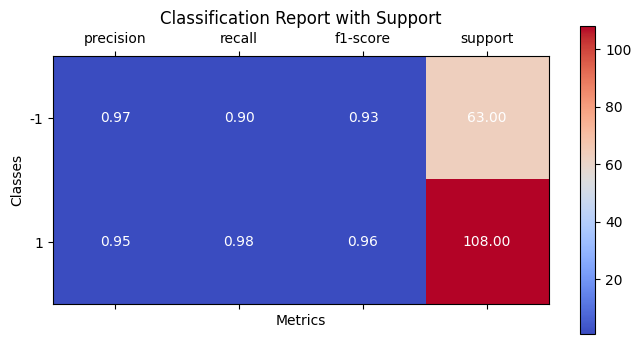

In [78]:
plot_classification_report_with_support(classification_report(y_test, y_pred, output_dict=True))

### Voted Perceptron

In [57]:
def voted_perceptron(X, y, epocas):
    n_samples, n_features = X.shape  # Número de instancias y características
    weights = np.zeros(n_features)  # Inicializa los pesos a ceros
    perceptrons = []  # Lista para almacenar los perceptrones y sus conteos
    count = 1  # Conteo de clasificaciones correctas consecutivas

    # Iterar sobre el número de épocas
    for _ in range(epocas):
        # Iterar sobre cada instancia en el conjunto de datos
        for idx, x_i in enumerate(X):
            # Verificar si la instancia está mal clasificada
            if y[idx] * np.dot(x_i, weights) <= 0:
                # Guardar el perceptrón actual y su conteo
                perceptrons.append((weights.copy(), count))
                # Actualizar los pesos usando la regla de actualización del perceptrón
                weights += y[idx] * x_i
                # Reiniciar el conteo después de una actualización de pesos
                count = 1
            else:
                # Incrementar el conteo si la instancia está correctamente clasificada
                count += 1

    # Guardar el último perceptrón y su conteo
    perceptrons.append((weights.copy(), count))
    return perceptrons

def predict_voted_perceptron(X, perceptrons):
    predictions = np.zeros(X.shape[0])  # Inicializa las predicciones a ceros

    # Iterar sobre cada perceptrón y su conteo
    for weights, count in perceptrons:
        # Sumar las predicciones ponderadas de cada perceptrón
        predictions += count * np.sign(np.dot(X, weights))

    # Aplicar la función signo para obtener las predicciones finales
    return np.sign(predictions)



In [58]:
perceptrons = voted_perceptron(X_train, y_train, epochs=1000)

In [59]:
y_pred_VP = predict_voted_perceptron(X_test, perceptrons)

In [60]:
print(classification_report(y_test, y_pred_VP))

              precision    recall  f1-score   support

          -1       0.98      0.94      0.96        63
           1       0.96      0.99      0.98       108

    accuracy                           0.97       171
   macro avg       0.97      0.96      0.97       171
weighted avg       0.97      0.97      0.97       171



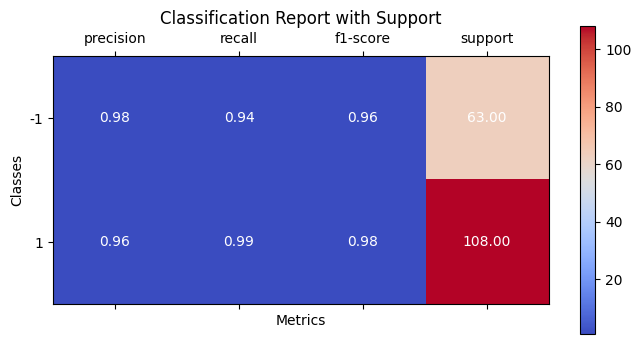

In [79]:
plot_classification_report_with_support(classification_report(y_test, y_pred_VP,output_dict=True))